# Continuous Evaluation

In [1]:
# change these to try this notebook out
BUCKET = 'munn-sandbox'
PROJECT = 'munn-sandbox'
REGION = 'us-central1'

In [2]:
import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION
os.environ['TFVERSION'] = '2.1'

In [3]:
import tensorflow as tf
print(tf.__version__)

2.1.1


In [4]:
%%bash
gsutil ls gs://$BUCKET/txtcls/data/

gs://munn-sandbox/txtcls/data/titles_full.csv
gs://munn-sandbox/txtcls/data/titles_sample.csv


In [5]:
!gsutil cp gs://$BUCKET/txtcls/data/titles_full.csv .

Copying gs://munn-sandbox/txtcls/data/titles_full.csv...
/ [1 files][  5.4 MiB/  5.4 MiB]                                                
Operation completed over 1 objects/5.4 MiB.                                      


In [6]:
import pandas as pd
from tensorflow.keras.utils import to_categorical

DATASET_NAME = "titles_full.csv"
COLUMNS = ['title', 'source']

titles_df = pd.read_csv(DATASET_NAME, header=None, names=COLUMNS)
titles_df.head()

,title,source
0,led inventor and employer settle for $8.1m 2005,nytimes
1,yc-backed photo-sharing service picplum loses ...,techcrunch
2,as facebook turns 10 zuckerberg wants to chan...,nytimes
3,6 big healthtech ideas that will change medici...,techcrunch
4,building the prince of persia sources to creat...,github


In [7]:
CLASSES = {
    'github': 0,
    'nytimes': 1,
    'techcrunch': 2
}
N_CLASSES = len(CLASSES)

In [8]:
def encode_labels(sources):
    classes = [CLASSES[source] for source in sources]
    one_hots = to_categorical(classes, num_classes=N_CLASSES)
    return one_hots

In [9]:
encode_labels(titles_df.source[:4])

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [10]:
N_TRAIN = int(len(titles_df) * 0.95)

titles_train, sources_train = (
    titles_df.title[:N_TRAIN], titles_df.source[:N_TRAIN])

titles_valid, sources_valid = (
    titles_df.title[N_TRAIN:], titles_df.source[N_TRAIN:])

In [11]:
X_train, Y_train = titles_train.values, encode_labels(sources_train)
X_valid, Y_valid = titles_valid.values, encode_labels(sources_valid)

In [12]:
X_train[:3]

array(['led inventor and employer settle for $8.1m  2005 ',
       'yc-backed photo-sharing service picplum loses one co-founder',
       'as facebook turns 10  zuckerberg wants to change how tech industry works'],
      dtype=object)

## Swivel Model

Then we will try a word embedding obtained using [Swivel](https://arxiv.org/abs/1602.02215), an algorithm that essentially factorizes word co-occurrence matrices to create the words embeddings. 
TF-Hub hosts the pretrained [gnews-swivel-20dim-with-oov](https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1) 20-dimensional Swivel module.

In [13]:
import shutil

import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow_hub import KerasLayer
from tensorflow.keras.layers import Dense, Input, Lambda
from tensorflow.keras.models import Sequential, Model

%matplotlib inline

In [14]:
print(tf.__version__)

2.1.1


In [15]:
SWIVEL = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1"
swivel_module = KerasLayer(
    SWIVEL, output_shape=[20], input_shape=[], dtype=tf.string, trainable=True)

In [16]:
def build_model(hub_module, name):
    inputs = Input(shape=[], dtype=tf.string, name="text")
    module = hub_module(inputs)
    h1 = Dense(16, activation='relu', name="h1")(module)
    outputs = Dense(N_CLASSES, activation='softmax', name='outputs')(h1)
    model = Model(inputs=inputs, outputs=[outputs], name='txtcls_model')
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [17]:
def train_and_evaluate(train_data, val_data, model, batch_size=5000):
    tf.random.set_seed(33)    
    X_train, Y_train = train_data

    history = model.fit(
        X_train, Y_train,
        epochs=100,
        batch_size=batch_size,
        validation_data=val_data,
        callbacks=[EarlyStopping()],
    )
    return history

In [18]:
txtcls_model = build_model(swivel_module, name='swivel')

In [19]:
txtcls_model.summary()

Model: "txtcls_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text (InputLayer)            [(None,)]                 0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 20)                389380    
_________________________________________________________________
h1 (Dense)                   (None, 16)                336       
_________________________________________________________________
outputs (Dense)              (None, 3)                 51        
Total params: 389,767
Trainable params: 389,767
Non-trainable params: 0
_________________________________________________________________


In [20]:
data = (X_train, Y_train)
val_data = (X_valid, Y_valid)

For training we'll call `train_and_evaluate` on `txtcls_model`.

In [22]:
txtcls_history = train_and_evaluate(data, val_data, txtcls_model)

Train on 91392 samples, validate on 4811 samples
Epoch 1/100
91392/91392 [==============================] - 1s 15us/sample - loss: 1.1208 - accuracy: 0.3737 - val_loss: 1.0781 - val_accuracy: 0.4184
Epoch 2/100
91392/91392 [==============================] - 1s 7us/sample - loss: 1.0498 - accuracy: 0.4471 - val_loss: 1.0240 - val_accuracy: 0.4804
Epoch 3/100
91392/91392 [==============================] - 1s 6us/sample - loss: 0.9987 - accuracy: 0.5078 - val_loss: 0.9791 - val_accuracy: 0.5327
Epoch 4/100
91392/91392 [==============================] - 1s 6us/sample - loss: 0.9531 - accuracy: 0.5498 - val_loss: 0.9351 - val_accuracy: 0.5714
Epoch 5/100
91392/91392 [==============================] - 1s 6us/sample - loss: 0.9068 - accuracy: 0.5844 - val_loss: 0.8884 - val_accuracy: 0.6061
Epoch 6/100
91392/91392 [==============================] - 1s 6us/sample - loss: 0.8570 - accuracy: 0.6167 - val_loss: 0.8374 - val_accuracy: 0.6373
Epoch 7/100
91392/91392 [==============================]

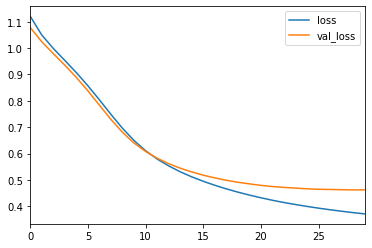

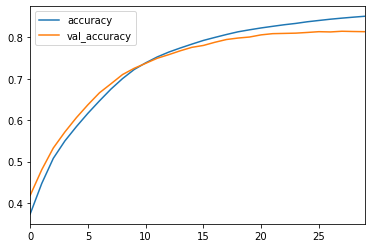

In [23]:
history = txtcls_history
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()

Calling predicition from model head produces output from final dense layer. This is what isused to compute categorical cross-entropy when training. 

In [24]:
txtcls_model.predict(x=["YouTube introduces Video Chapters to make it easier to navigate longer videos"])

array([[0.28770897, 0.12664415, 0.58564687]], dtype=float32)

Calling prediction from the evaluation_head provides the output required from CAIP Continuous Evaluation.

In [25]:
tf.saved_model.save(txtcls_model, './txtcls_model/')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: ./txtcls_model/assets


INFO:tensorflow:Assets written to: ./txtcls_model/assets


In [26]:
!saved_model_cli show \
 --tag_set serve \
 --signature_def serving_default \
 --dir ./txtcls_model/

2020-06-10 03:27:23.374499: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2020-06-10 03:27:23.376274: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
The given SavedModel SignatureDef contains the following input(s):
  inputs['text'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: serving_default_text:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['outputs'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 3)
      name: StatefulPartitionedCall_2:0
Method name is: tensorflow/serving/predict


Modify the model signature to output source title (either 'nytimes', 'techcrunch', or 'github') and the model confidence.

In [27]:
@tf.function(input_signature=[tf.TensorSpec([None], dtype=tf.string)])
def source_name(text):
    labels = tf.constant(['github', 'techcrunch', 'nytimes'], dtype=tf.string)
    probs = txtcls_model(text, training=False)
    indices = tf.argmax(probs, axis=1)
    pred_source = tf.gather(params=labels, indices=indices)
    pred_confidence = tf.reduce_max(probs, axis=1)
    return {'source': pred_source,
            'confidence': pred_confidence}

Re-save the new swivel_model that has the updated model signature.

In [30]:
shutil.rmtree('./txtcls_model', ignore_errors=True)
txtcls_model.save('./txtcls_model', signatures={'serving_default': source_name})

INFO:tensorflow:Assets written to: ./txtcls_model/assets


INFO:tensorflow:Assets written to: ./txtcls_model/assets


Examine the model signature to confirm the changes

In [31]:
!saved_model_cli show \
 --tag_set serve \
 --signature_def serving_default \
 --dir ./txtcls_model/

2020-06-10 03:28:12.799068: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2020-06-10 03:28:12.800876: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
The given SavedModel SignatureDef contains the following input(s):
  inputs['text'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: serving_default_text:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['confidence'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: StatefulPartitionedCall_2:0
  outputs['source'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: StatefulPartitionedCall_2:1
Method name is: tensorflow/serving/predict


Call predictions using the corrected serving input function

In [32]:
title1 = "A Filmmaker Put Away for Tax Fraud Takes Us Inside a British Prison"
title2 = "YouTube introduces Video Chapters to make it easier to navigate longer videos"
title3 = "A native Mac app wrapper for WhatsApp Web"

restored = tf.keras.models.load_model('./txtcls_model')
infer = restored.signatures['serving_default']
outputs = infer(text=tf.constant([title1, title2, title3]))

In [33]:
print(outputs['source'].numpy())
print(outputs['confidence'].numpy())

[b'github' b'nytimes' b'github']
[0.93742085 0.5856467  0.95376575]


## Deploy model

In [34]:
%%bash
MODEL_NAME="txtcls"
MODEL_VERSION="swivel"
MODEL_LOCATION="./txtcls_model/"
BUCKET="munn-sandbox"

gcloud ai-platform versions create ${MODEL_VERSION} \
--model ${MODEL_NAME} \
--origin ${MODEL_LOCATION} \
--staging-bucket gs://${BUCKET} \
--runtime-version=2.1

Creating version (this might take a few minutes)......
.....................................................................................................................................................................................................................................................................................................done.


## Set up the Evaluation job on CAIP

Go to Google Cloud Platform to see the model version you've deployed. And set up an evaluation job.

In [200]:
# some stuff here about setting up Eval jobs
# look at the BQ table you created, nothing is there

In [ ]:
%load_ext google.cloud.bigquery

In [72]:
%%bigquery
SELECT * FROM `munn-sandbox.txtcls_eval.swivelv2_eval_job`

,model,model_version,time,raw_data,raw_prediction,groundtruth


## Send prediction requests to your model

We'll create a .json file with multiple titles for prediction

| title  | source  |
|---|---|
| YouTube introduces Video Chapters to make it easier to navigate longer videos  |  techcrunch |
| A Filmmaker Put Away for Tax Fraud Takes Us Inside a British Prison | nytimes |
| A native Mac app wrapper for WhatsApp Web | github |

In [39]:
%%writefile input.json
{"text": "YouTube introduces Video Chapters to make it easier to navigate longer videos"}

Overwriting input.json


In [28]:
!gcloud ai-platform predict \
  --model txtcls \
  --json-instances input.json \
  --version swivel_eval_v2

CONFIDENCE  SOURCE
0.992685    github


In [29]:
%%writefile input.json
{"text": "Astronauts Dock With Space Station After Historic SpaceX Launch"}

Overwriting input.json


In [30]:
!gcloud ai-platform predict \
  --model txtcls \
  --json-instances input.json \
  --version swivel_eval_v2

CONFIDENCE  SOURCE
0.999428    github


In [20]:
%%writefile input.json
{"text": "The Supreme Court, Too, Is on the Brink"}

Overwriting input.json


In [21]:
!gcloud ai-platform predict \
  --model txtcls \
  --json-instances input.json \
  --version swivel_eval_v2

CONFIDENCE  SOURCE
0.918685    techcrunch


Summarizing the results from our model:

| title  | source  | predicted_source | 
|---|---|---|
| YouTube introduces Video Chapters to make it easier to navigate longer videos  |  techcrunch | nytimes |
| A Filmmaker Put Away for Tax Fraud Takes Us Inside a British Prison | nytimes | github | 
| A native Mac app wrapper for WhatsApp Web | github | github |

In [22]:
%%bigquery
SELECT * FROM `munn-sandbox.txtcls_eval.swivelv2_eval_job`

,model,model_version,time,raw_data,raw_prediction,groundtruth
0,txtcls,swivel_eval_v2,2020-06-10 01:35:27+00:00,"{""instances"": [{""text"": ""Decrypted: DEA spying...","{""predictions"": [{""source"": ""nytimes"", ""confid...","{predictions"": [{""source"": ""techcrunch""}]}"
1,txtcls,swivel_eval_v2,2020-06-10 01:37:46+00:00,"{""instances"": [{""text"": ""Senate Confirms First...","{""predictions"": [{""source"": ""github"", ""confide...",None
2,txtcls,swivel_eval_v2,2020-06-09 21:21:44+00:00,"{""instances"": [{""text"": ""YouTube introduces Vi...","{""predictions"": [{""source"": ""nytimes"", ""confid...","{predictions"": [{""source"": ""techcrunch""}]}"
3,txtcls,swivel_eval_v2,2020-06-10 01:34:42+00:00,"{""instances"": [{""text"": ""Transparent face mask...","{""predictions"": [{""source"": ""nytimes"", ""confid...","{predictions"": [{""source"": ""techcrunch""}]}"
4,txtcls,swivel_eval_v2,2020-06-10 01:34:36+00:00,"{""instances"": [{""text"": "" Does tech have the g...","{""predictions"": [{""source"": ""techcrunch"", ""con...","{predictions"": [{""source"": ""techcrunch""}]}"
5,txtcls,swivel_eval_v2,2020-06-09 21:21:47+00:00,"{""instances"": [{""text"": ""A native Mac app wrap...","{""predictions"": [{""source"": ""github"", ""confide...","{predictions"": [{""source"": ""github""}]}"
6,txtcls,swivel_eval_v2,2020-06-10 01:37:22+00:00,"{""instances"": [{""text"": ""G.O.P. Scrambles to R...","{""predictions"": [{""source"": ""github"", ""confide...",None
7,txtcls,swivel_eval_v2,2020-06-09 21:21:46+00:00,"{""instances"": [{""text"": ""A Filmmaker Put Away ...","{""predictions"": [{""source"": ""github"", ""confide...","{predictions"": [{""source"": ""nytimes""}]}"
8,txtcls,swivel_eval_v2,2020-06-10 01:38:13+00:00,"{""instances"": [{""text"": ""The Supreme Court, To...","{""predictions"": [{""source"": ""techcrunch"", ""con...",None


## Provide the ground truth for the raw prediction input

In [31]:
%%bigquery
UPDATE `txtcls_eval.swivelv2_eval_job`
SET 
    groundtruth = '{predictions": [{"source": "nytimes"}]}'
WHERE
    raw_data = '{"instances": [{"text": "A Filmmaker Put Away for Tax Fraud Takes Us Inside a British Prison"}]}';

""


In [32]:
%%bigquery
UPDATE `txtcls_eval.swivelv2_eval_job`
SET 
    groundtruth = '{predictions": [{"source": "techcrunch"}]}'
WHERE
    raw_data = '{"instances": [{"text": "YouTube introduces Video Chapters to make it easier to navigate longer videos"}]}';

""


In [25]:
%%bigquery
UPDATE `txtcls_eval.swivelv2_eval_job`
SET 
    groundtruth = '{predictions": [{"source": "github"}]}'
WHERE
    raw_data = '{"instances": [{"text": "A native Mac app wrapper for WhatsApp Web"}]}';

""


In [33]:
%%bigquery
SELECT * FROM `munn-sandbox.txtcls_eval.swivelv2_eval_job`

,model,model_version,time,raw_data,raw_prediction,groundtruth
0,txtcls,swivel_eval_v2,2020-06-10 01:34:36+00:00,"{""instances"": [{""text"": "" Does tech have the g...","{""predictions"": [{""source"": ""techcrunch"", ""con...","{predictions"": [{""source"": ""techcrunch""}]}"
1,txtcls,swivel_eval_v2,2020-06-10 01:40:05+00:00,"{""instances"": [{""text"": ""Where Protesters Go, ...","{""predictions"": [{""source"": ""github"", ""confide...","{predictions"": [{""source"": ""nytimes""}]}"
2,txtcls,swivel_eval_v2,2020-06-10 01:35:27+00:00,"{""instances"": [{""text"": ""Decrypted: DEA spying...","{""predictions"": [{""source"": ""nytimes"", ""confid...","{predictions"": [{""source"": ""techcrunch""}]}"
3,txtcls,swivel_eval_v2,2020-06-09 21:21:44+00:00,"{""instances"": [{""text"": ""YouTube introduces Vi...","{""predictions"": [{""source"": ""nytimes"", ""confid...","{predictions"": [{""source"": ""techcrunch""}]}"
4,txtcls,swivel_eval_v2,2020-06-10 01:34:42+00:00,"{""instances"": [{""text"": ""Transparent face mask...","{""predictions"": [{""source"": ""nytimes"", ""confid...","{predictions"": [{""source"": ""techcrunch""}]}"
5,txtcls,swivel_eval_v2,2020-06-10 01:40:32+00:00,"{""instances"": [{""text"": ""Astronauts Dock With ...","{""predictions"": [{""source"": ""github"", ""confide...","{predictions"": [{""source"": ""nytimes""}]}"
6,txtcls,swivel_eval_v2,2020-06-10 01:38:13+00:00,"{""instances"": [{""text"": ""The Supreme Court, To...","{""predictions"": [{""source"": ""techcrunch"", ""con...","{predictions"": [{""source"": ""nytimes""}]}"
7,txtcls,swivel_eval_v2,2020-06-09 21:21:46+00:00,"{""instances"": [{""text"": ""A Filmmaker Put Away ...","{""predictions"": [{""source"": ""github"", ""confide...","{predictions"": [{""source"": ""nytimes""}]}"
8,txtcls,swivel_eval_v2,2020-06-10 01:37:22+00:00,"{""instances"": [{""text"": ""G.O.P. Scrambles to R...","{""predictions"": [{""source"": ""github"", ""confide...","{predictions"": [{""source"": ""nytimes""}]}"
9,txtcls,swivel_eval_v2,2020-06-09 21:21:47+00:00,"{""instances"": [{""text"": ""A native Mac app wrap...","{""predictions"": [{""source"": ""github"", ""confide...","{predictions"": [{""source"": ""github""}]}"


## Compute evaluation metrics

Using regex we can extract the model predictions

In [35]:
%%bigquery
SELECT
  model,
  model_version,
  time,
  REGEXP_EXTRACT(raw_data, r'.*"text": "(.*)"') AS text,
  REGEXP_EXTRACT(raw_prediction, r'.*"source": "(.*?)"') AS prediction,
  REGEXP_EXTRACT(raw_prediction, r'.*"confidence": (0.\d{2}).*') AS confidence,
  REGEXP_EXTRACT(groundtruth, r'.*"source": "(.*?)"') AS groundtruth,
FROM
  `txtcls_eval.swivelv2_eval_job`

,model,model_version,time,text,prediction,confidence,groundtruth
0,txtcls,swivel_eval_v2,2020-06-10 01:37:46+00:00,Senate Confirms First Black Air Force Chief,nytimes,0.99,nytimes
1,txtcls,swivel_eval_v2,2020-06-10 01:38:13+00:00,"The Supreme Court, Too, Is on the Brink",nytimes,0.77,nytimes
2,txtcls,swivel_eval_v2,2020-06-10 01:40:05+00:00,"Where Protesters Go, Street Medics Follow",nytimes,0.99,nytimes
3,txtcls,swivel_eval_v2,2020-06-10 01:40:32+00:00,Astronauts Dock With Space Station After Histo...,github,0.99,nytimes
4,txtcls,swivel_eval_v2,2020-06-09 21:21:46+00:00,A Filmmaker Put Away for Tax Fraud Takes Us In...,github,0.98,nytimes
5,txtcls,swivel_eval_v2,2020-06-10 01:34:36+00:00,Does tech have the guts to deploy its resourc...,techcrunch,0.62,techcrunch
6,txtcls,swivel_eval_v2,2020-06-09 21:21:47+00:00,A native Mac app wrapper for WhatsApp Web,github,0.74,github
7,txtcls,swivel_eval_v2,2020-06-10 01:34:42+00:00,Transparent face mask startup inhales $1M seed...,nytimes,0.98,techcrunch
8,txtcls,swivel_eval_v2,2020-06-09 21:21:44+00:00,YouTube introduces Video Chapters to make it e...,techcrunch,0.77,techcrunch
9,txtcls,swivel_eval_v2,2020-06-10 01:37:22+00:00,G.O.P. Scrambles to Respond to Public Demands ...,github,0.99,nytimes


In [37]:
from google.cloud import bigquery

In [38]:
query = '''
SELECT
  model,
  model_version,
  time,
  REGEXP_EXTRACT(raw_data, r'.*"text": "(.*)"') AS text,
  REGEXP_EXTRACT(raw_prediction, r'.*"source": "(.*?)"') AS prediction,
  REGEXP_EXTRACT(raw_prediction, r'.*"confidence": (0.\d{2}).*') AS confidence,
  REGEXP_EXTRACT(groundtruth, r'.*"source": "(.*?)"') AS groundtruth,
FROM
  `txtcls_eval.swivelv2_eval_job`
'''

client = bigquery.Client()
df_results = client.query(query).to_dataframe()

In [45]:
df_results.head(20)

,model,model_version,time,text,prediction,confidence,groundtruth
0,txtcls,swivel_eval_v2,2020-06-10 01:38:13+00:00,"The Supreme Court, Too, Is on the Brink",nytimes,0.77,nytimes
1,txtcls,swivel_eval_v2,2020-06-10 01:40:05+00:00,"Where Protesters Go, Street Medics Follow",nytimes,0.99,nytimes
2,txtcls,swivel_eval_v2,2020-06-10 01:37:46+00:00,Senate Confirms First Black Air Force Chief,nytimes,0.99,nytimes
3,txtcls,swivel_eval_v2,2020-06-09 21:21:46+00:00,A Filmmaker Put Away for Tax Fraud Takes Us In...,github,0.98,nytimes
4,txtcls,swivel_eval_v2,2020-06-09 21:21:44+00:00,YouTube introduces Video Chapters to make it e...,techcrunch,0.77,techcrunch
5,txtcls,swivel_eval_v2,2020-06-10 01:40:32+00:00,Astronauts Dock With Space Station After Histo...,github,0.99,nytimes
6,txtcls,swivel_eval_v2,2020-06-10 01:34:42+00:00,Transparent face mask startup inhales $1M seed...,nytimes,0.98,techcrunch
7,txtcls,swivel_eval_v2,2020-06-10 01:35:27+00:00,"Decrypted: DEA spying on protesters, DDoS atta...",nytimes,0.68,techcrunch
8,txtcls,swivel_eval_v2,2020-06-10 01:37:22+00:00,G.O.P. Scrambles to Respond to Public Demands ...,github,0.99,nytimes
9,txtcls,swivel_eval_v2,2020-06-10 01:34:36+00:00,Does tech have the guts to deploy its resourc...,techcrunch,0.62,techcrunch


In [101]:
prediction = list(df_results.prediction)
groundtruth = list(df_results.groundtruth)

In [105]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import multilabel_confusion_matrix

precision, recall, fscore, support = score(groundtruth, prediction)

In [103]:
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.25 0.6  1.  ]
recall: [1.  0.5 0.5]
fscore: [0.4        0.54545455 0.66666667]
support: [1 6 4]


In [104]:
from tabulate import tabulate
sources = list(CLASSES.keys())
results = list(zip(sources, precision, recall, fscore, support))
tabulate(results, headers = ['source', 'precision', 'recall', 'fscore', 'support'],
         tablefmt='orgtbl')

| source     |   precision |   recall |   fscore |   support |
|------------+-------------+----------+----------+-----------|
| github     |        0.25 |      1   | 0.4      |         1 |
| nytimes    |        0.6  |      0.5 | 0.545455 |         6 |
| techcrunch |        1    |      0.5 | 0.666667 |         4 |


Compute confusion matrix

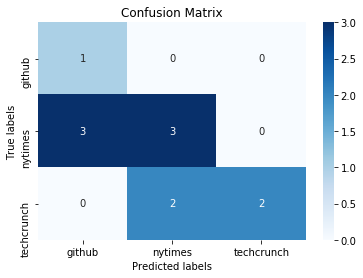

In [128]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
cm = confusion_matrix(groundtruth, prediction, labels=sources)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap="Blues")

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(sources)
ax.yaxis.set_ticklabels(sources)
plt.savefig("./txtcls_cm.png")